In [3]:
import sys
sys.path.append('../web/')

In [4]:
from itertools import cycle

import numpy as np
from pandas import DataFrame
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scikits.audiolab import aiffread
from librosa import frames_to_time, hz_to_midi, midi_to_hz, peak_pick
from librosa.feature import rmse, melspectrogram, spectral_centroid, spectral_bandwidth
from librosa.onset import onset_detect, onset_strength
from IPython.display import Audio

import utils
import objects

### Load the audio file
The first step is to load the audio file. I snipped a bunch of samples from an episode of Dr. Katz, Professional Therapist [S3E5, Koppleman and Katz](https://www.youtube.com/watch?v=YUVqMFVeQVg). Here's Dr. Katz saying *"She was my old lady as they used to say in those days."*

In [23]:
vox_48k, sr_48k, _ = aiffread('../audio/k09.aif')
t_48k = np.arange(vox_48k.size, dtype=float)/sr_48k
Audio(data=vox_48k, rate=sr_48k)

## Initialize pyo server

In [24]:
import pyo64 as pyo
s = pyo.Server(sr=sr_48k).boot()

### Downsample
Real-time needs to be fast, so I decimate the original audio by a factor of 4 (48 kHz to 12 kHz). This puts our Nyquist frequency at 6 kHz, which should capture all the frequencies relevant for human speech.

In [25]:
downsample = 4
vox_12k = vox_48k[::downsample]
sr_12k = sr_48k/downsample
t_12k = t_48k[::downsample]

nfft = 1024
frame_size = nfft
hop_length = 256

### Frame and window the audio
A few of the subsequent analyses will require the audio to be broken up into overlapping **frames**. This preprocessing step will be useful to efficiently calculate the **autocorrelogram** and **spectrogram**. I frame and window the audio once in the beginning and pass it around as needed.

In [26]:
vox_windowed = utils.frame_and_window_sound(vox_12k, hop_length=hop_length)
t_frames = frames_to_time(np.arange(vox_windowed.shape[1]), sr=sr_12k, hop_length=hop_length) + (frame_size/2.)/sr_12k

Here's what *frame 4* sounds like--it's the start of the *"sh"* sound in *"She."* As you can see, the window emphasizes sound in the middle of the frame and tapers off in the beginning and end of the frame.

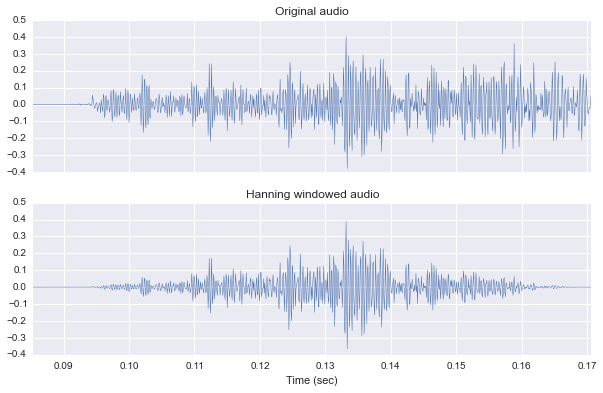

In [31]:
frame_num = 4
frame_start_ix = frame_num*hop_length
fig, axs = plt.subplots(2,1, figsize=(10, 6), sharex=True, sharey=True);
t = t_12k[frame_start_ix:frame_start_ix+frame_size]
axs[0].plot(t, vox_12k[frame_start_ix:frame_start_ix+frame_size], lw=0.5);
axs[0].set_title('Original audio')
axs[1].plot(t, vox_windowed[:,frame_num], lw=0.5);
axs[1].set_title('Hanning windowed audio')
axs[1].set_xlim([t[0], t[-1]]);
axs[1].set_xlabel('Time (sec)')
Audio(data=vox_windowed[:,frame_num], rate=sr_12k)

## Harmonicity from autocorrelation

If I want to generate a melody from a speech sample, I need to extract the **pitch**, which for the human voice corresponds to the **fundamental frequency** or **f0**. One computationally cheap and conceptually simple way to do that is using the autocorrelation.

The autocorrelation of the sound at a given frame gives us a measure of how **periodic** the speech is at that moment. I'm guessing that a lot of the noise I'll want to eliminate (brushing or hitting the mic, wind, environmental sounds) will be **aperiodic** or "noisy," so the **periodicity** will give me a decent estimate of which frames to include or exclude as non-speech sounds. (Not all speech sounds are periodic, only **voiced** ones. **Unvoiced** speech sounds (**sibilants** like "s" and "f") are primarily noise, but they usually occur in close proximity to voiced speech. Expanding the voiced periods forward and backward in time should capture these unvoiced speech sounds as well.)

Here is an example of **unvoiced** (*frame 4*, the "sh" in "She") and **voiced** (*frame 10*, the "ee" from the end of "She") frames.

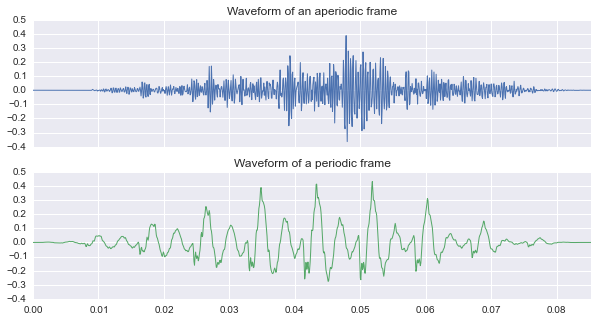

In [32]:
color_cycle = cycle(sns.color_palette())
fig, axs = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True);
t = t_12k[:frame_size]
axs[0].plot(t, vox_windowed[:,4], lw=1, c=next(color_cycle));
axs[0].set_title('Waveform of an aperiodic frame');
axs[1].plot(t, vox_windowed[:,10], lw=1, c=next(color_cycle));
axs[1].set_xlim([0, t[-1]]);
axs[1].set_title('Waveform of a periodic frame');

In [33]:
vox_fft = np.fft.rfft(vox_windowed, n=nfft, axis=0)
vox_spectrogram = np.abs(vox_fft**2)
autocorr, periodicity, is_voiced = utils.calc_vocal_periodicity(vox_fft, voiced_thresh=1.5)
is_voiced_sum = is_voiced.sum()

Now here are the autocorrelations for the same two frames. I've restricted the autocorrelation to only those frequencies that are potentially human **f0** (60-300 Hz). The measure of **periodicity** simply takes the maximum value from this region of the autocorrelation. The **voiced** "ee" has a max of 10.64, while the **unvoiced** "sh" has a max of 0.74. Very clear.

"sh" max=1.14, "ee" max=9.81


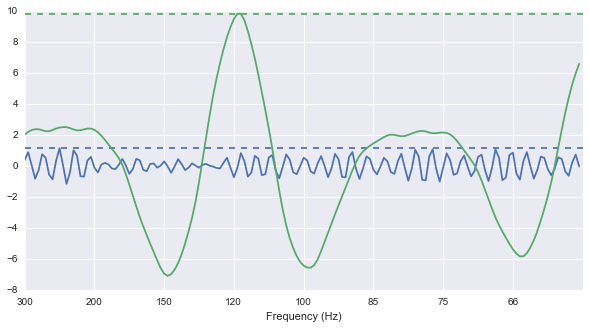

In [34]:
color_cycle = cycle(sns.color_palette())
clr = next(color_cycle)
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(autocorr[:,4], c=clr);
max_4 = autocorr[:,4].max()
ax.axhline(max_4, color=clr, ls='--')
clr = next(color_cycle)
ax.plot(autocorr[:,10], c=clr);
max_10 = autocorr[:,10].max()
ax.axhline(max_10, color=clr, ls='--')

f_acorr = sr_12k/np.arange(40,200)
xticks = ax.get_xticks()[:-1]
ax.set_xticklabels((f_acorr[xticks.astype(int)]).astype(int))
ax.set_xlabel('Frequency (Hz)');
print '"sh" max=%2.2f, "ee" max=%2.2f' % (max_4, max_10)

## Speech or not?
Our estimate of what should be considered speech and what should not begins with the **voiced** frames. Most "accidental" sounds (mic bumps, etc) will be noisy. But speech also contains noisy sounds (sibilants). However, we can reasonably expect those sounds to occur close to voiced sounds. So we expand the voiced frames a few milliseconds on either side and consider this widened window to contain all speech sounds.

One issue is obvious. Look at the end of the sample. The "f" sound at the end of "life" is a drawn out *unvoiced labiodental fricative*, but it is not included in the speech window.

In [41]:
is_speech = np.convolve(is_voiced, np.ones(10.)/10., 'same')>0
t_spec = t_frames[is_speech]
mel_spectrogram_speech = melspectrogram(S=np.abs(vox_fft[5:213,is_speech])**2)

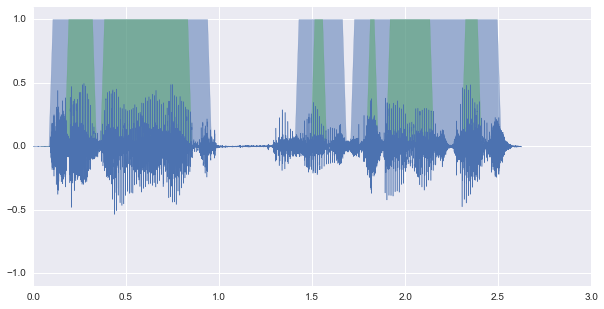

In [36]:
color_cycle = cycle(sns.color_palette())
fig, ax = plt.subplots(figsize=(10, 5));
ax.fill_between(t_frames, np.zeros_like(is_speech), is_speech, alpha=0.5, color=next(color_cycle));
ax.fill_between(t_frames, np.zeros_like(is_voiced), is_voiced, alpha=0.5, color=next(color_cycle));
ax.plot(t_48k, vox_48k, lw=0.5)
ax.set_ylim([-1.1, 1.1]);

## Pitch tracking with priors
I use the same region of the autocorrelation to detect the **pitch** or **fundamental frequency (f0)** of **voiced** frames. Take another look at the autocorrelation trace for the "ee" sound (the green one). The largest peak is luckily at the actual **f0** around 130 Hz. However, The peak at half that frequency (near 65 Hz) is nearly as large. Why not guide our detection a bit to focus on good, natural, human fundamental frequencies?

To do this, I take a Bayesian approach of applying a **prior** to the autocorrelation. The prior is our expectation of where the f0 should be. For this I use a normal distribution in log space (since pitch perception is log-based) centered on 120 Hz for Dr. Katz, which is fairly typical for an adult male. In practice, I estimate the participant's f0 as they are getting set up and discretely type it into the computer. Eventually, it would be better to have the computer learn this.

Multiplying the prior by the observed autocorrelation gives us a much more stable estimate of f0.

In [37]:
f0_center = 120.
pitch_prior = norm.pdf(np.log2(sr_12k/np.arange(40,200)), np.log2(f0_center), 0.5)
pitch = utils.pitch_track(autocorr, sr_12k, pitch_prior, is_voiced)

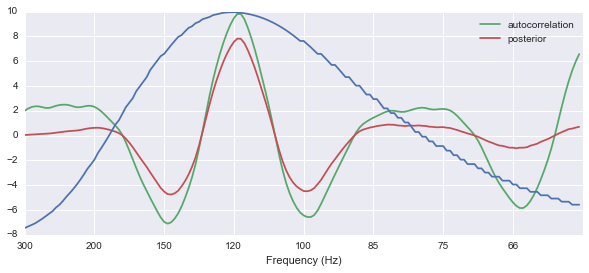

In [38]:
color_cycle = cycle(sns.color_palette())
fig, ax0 = plt.subplots(figsize=(10, 4), sharex=True)
ax1 = ax0.twinx();
ax1.grid('off'); ax1.set_yticklabels([]);

ax1.plot(pitch_prior, c=next(color_cycle), label='prior');
ax0.plot(autocorr[:,10], c=next(color_cycle), label='autocorrelation');
ax0.plot(pitch_prior*autocorr[:,10], c=next(color_cycle), label='posterior');

ax0.legend()
xticks = ax0.get_xticks()[:-1]
ax0.set_xticklabels(f_acorr[xticks.astype(int)].astype(int))
ax0.set_xlabel('Frequency (Hz)');

In [39]:
ampl = rmse(S=vox_fft).flatten()

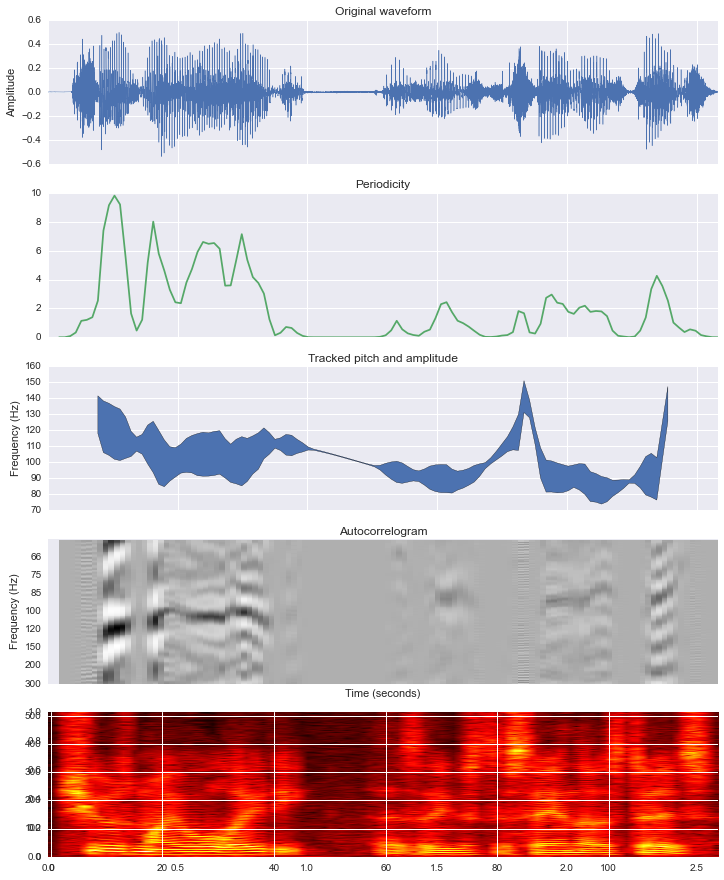

In [40]:
color_cycle = cycle(sns.color_palette())
fig, axs = plt.subplots(5, 1,figsize=(12, 15), sharex=True);
axs[0].plot(t_48k, vox_48k, lw=0.5, color=next(color_cycle));
axs[0].set_title('Original waveform');
axs[0].set_ylabel('Amplitude');
# axs[1].imshow(autocorr, aspect='auto')
# axs[1].set_title('Autocorrelogram');
axs[1].plot(t_frames, periodicity, color=next(color_cycle));
axs[1].set_title('Periodicity');
axs[2].fill_between(t_frames, pitch+ampl*5, pitch-ampl*5);
axs[2].set_title('Tracked pitch and amplitude');
axs[2].set_ylabel('Frequency (Hz)');

axs[3].pcolor(t_frames, np.arange(autocorr.shape[0]), autocorr);
axs[3].set_title('Autocorrelogram');
axs[3].set_xlabel('Time (seconds)');
axs[3].set_xlim([0, t_frames[-1]]);
yticks = axs[3].get_yticks()[:-1]
axs[3].set_yticklabels(f_acorr[yticks.astype(int)]);
axs[3].set_ylabel('Frequency (Hz)');

ax = fig.add_subplot(5,1,5);
ax.imshow(vox_spectrogram**0.1, aspect='auto', origin='lower', cmap='hot')

Audio(data=vox_48k, rate=sr_48k)

So there you have it, pitch tracking on the audio input. The tracked pitch and amplitude are used by the *Groove* and *Melody* elements in slightly different ways, which I'll describe in a separate notebook.